In [1]:
from commonfunctions import *
import math

# Show the matlpotlib figures inside the notebook
%matplotlib inline

In [2]:
def eliminate_points_on_almost_straight_line(hull):
    if hull.shape[0] <= 4:
        return hull
    i = 0
    while i < hull.shape[0]:
        A1,B1,_ = line(hull[i - 1], hull[i])
        m1 = -A1 / B1
        A2,B2,_ = line(hull[i], hull[(i + 1) % hull.shape[0]])
        m2 = -A2 / B2
        angle = 0
        if B1 == 0:
            angle = abs(1 / m2)
        elif B2 == 0:
            angle = abs(1 / m1)
        else:
            angle = abs((m2 - m1) / (1 + m1 * m2))
        if angle <= 0.5:
            hull = np.delete(hull, i, axis=0)
            i -= 1
        i += 1
    return hull

def approx_hull_to_rectangular_shape(hull):
    while hull.shape[0] > 4:
        min_pair = ()
        min_dist = math.inf
        for i in range(hull.shape[0]):
            p = hull[i], hull[(i + 1) % hull.shape[0]], i
            d = distance(p)
            if d < min_dist:
                min_pair = p
                min_dist = d
        p1, p2, i = min_pair
        # # debug
        # img_copy = np.copy(image)
        # for i in range(hull.shape[0]):
        #     cv2.circle(img_copy, (hull[i][0],hull[i][1]), 4, (0, 0, 255), -1)
        #     cv2.imshow("ta" + str(asd), img_copy)
        #     cv2.waitKey(0)
        # #debug
        p_int = intersection(hull[i - 1], p1, p2, hull[(i + 2) % hull.shape[0]])
        hull[i] = p_int
        hull = np.delete(hull, [i, (i + 1) % hull.shape[0]], axis=0)
        if i > hull.shape[0]:
            hull = np.insert(hull, 0, p_int, axis=0)
            continue
        hull = np.insert(hull, i, p_int, axis=0)
    return hull

def fix_perspective(image):
    gray = cv2.GaussianBlur(image, (5, 5), 0)
    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    # #debug
    # cf.show_images([edged, gray])
    # #debug
    cnts = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    c = max(cnts, key = cv2.contourArea)
    hull = cv2.convexHull(c)[:, 0,:]
    # # debug
    # cv2.drawContours(image, [hull], -1, (0, 0, 255), 1)
    # # debug
    hull = eliminate_points_on_almost_straight_line(hull)
    rect = approx_hull_to_rectangular_shape(hull)
    # cv2.drawContours(image, [rect], -1, (255, 0, 0), 2)

    return four_point_transform(image, rect)

In [3]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # # debug
    # print(rect)
    # for x in rect:
    #     cv2.circle(image, tuple(x), 4, (0, 0, 255), -1)
    # # debug

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    fixed = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the fixed image
    return fixed

In [4]:
def order_points(pts):
    # sort the points based on their x-coordinates
    pts_indexes = np.argsort(pts[:, 0])
    xSorted = pts[pts_indexes, :]
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    tl_index = 0
    if xSorted[0][1] < xSorted[1][1]:
        tl_index = pts_indexes[0]
    else:
        tl_index = pts_indexes[1]
    result = []
    for i in range(tl_index, tl_index + 4, 1):
        result.append(pts[i % 4])
    return np.array(result, dtype="float32")

In [5]:
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(o1, p1, o2, p2):
    L1 = line(o1, p1)
    L2 = line(o2, p2)
    if abs(L1[0] - L2[0]) <= 0.01:
        return False
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = int(round(Dx / D))
        y = int(round(Dy / D))
        return [x, y]
    else:
        return False

def distance(p):
    p1, p2,_ = p
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [10]:
def deskew(img):
    edged = cv2.Canny(img, 50, 200, None, 3)
    linesP = cv2.HoughLinesP(edged, 1, np.pi / 180, min(img.shape[0], img.shape[1]) // 4, None, 0, 20)
    # if linesP is not None:
    #     for i in range(0, len(linesP)):
    #         l = linesP[i][0]
    #         cv2.line(img, (l[0], l[1]), (l[2], l[3]), (125,125,125), 3, cv2.LINE_AA)
    slopes = [(y2 - y1)/(x2 - x1) if (x2-x1) else math.inf for x1, y1, x2, y2 in linesP[:,0,:]]
    deg_angles = [round(np.degrees(np.arctan(x)), 2) for x in slopes]

    histo = np.histogram(deg_angles, bins=180)
    bar(histo[1][:180].astype(np.uint8), histo[0][:180], width=0.8, align='center')
    # most frequent slope of all lines
    rotation_number = histo[1][np.argmax(histo[0])]
    print(rotation_number)
    rotated = rotate(img, rotation_number, resize=True, mode="edge")
    if rotated.dtype != "uint8":
        return (rotated * 255).astype("uint8")
    return rotated

../inputs/test-set-camera-captured/test-cases
89.00372222222221


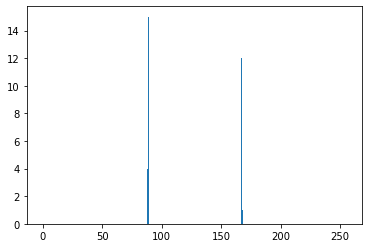

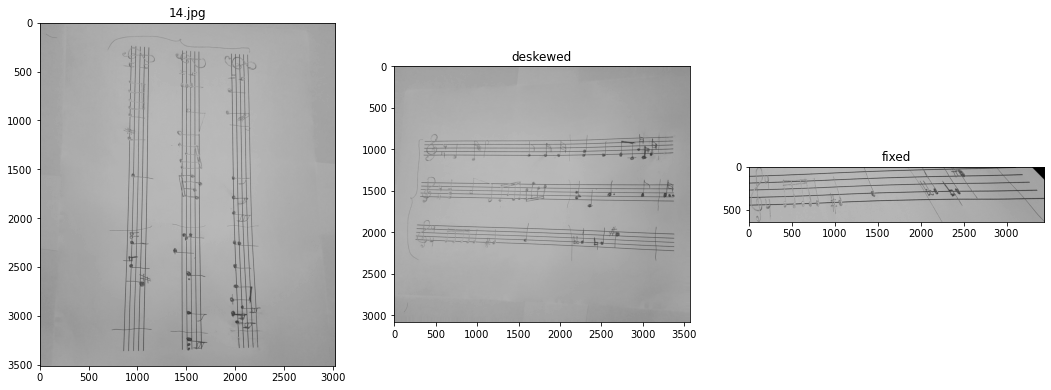

In [13]:
# images, files = load_images_from_folder("../inputs/test-set-scanned/test-cases")
images, files = load_images_from_folder("../inputs/test-set-camera-captured/test-cases")
images = [images[3]]
files = [files[3]]
outpath = "../outputs/"
for image, file in zip(images, files):
    deskewed = deskew(image)
    fixed = fix_perspective(deskewed)
    show_images([image, deskewed, fixed], [file, "deskewed", "fixed"])